In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit


In [22]:
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_clean.csv', index_col="time")
# Define features and target
X = df.drop(columns=['generation solar','generation wind onshore'])
y_solar = df['generation solar']
y_wind = df['generation wind onshore']

In [3]:
def prep_split(df, columns_drop, label, train_end_date, hours_ahead):
    # Add a column with the label shifted by "hours" rows

    if hours_ahead == 0:
        df['label_shifted'] = df[label]
    else:
        df['label_shifted'] = df[label].shift(-hours_ahead)
        # Drop the last "hours" rows as they have no label values
        df = df.iloc[:-hours_ahead]
   
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date]
        X_test = X[X.index > train_end_date]

        return X_train, X_test

    X = df.drop(columns=columns_drop + ['label_shifted'])
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = prep_split(df, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [10]:
# Format data for prophet model using ds and y

# Rename the index
y_train.index.name = 'ds'

# Rename the Series itself
y_train.name = 'y'

# Optionally, convert to a DataFrame
df_y = y_train.reset_index()

In [11]:
#Removing timezones
df_y['ds'] = df_y['ds'].dt.tz_localize(None)

In [12]:
%%time
model = Prophet()
model.fit(df_y)

16:38:06 - cmdstanpy - INFO - Chain [1] start processing
16:38:26 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.14 s, sys: 355 ms, total: 3.5 s
Wall time: 24.2 s


In [13]:
y_test.index.name = 'ds'

# Rename the Series itself
y_test.name = 'y'

# Optionally, convert to a DataFrame
df_y_test = y_test.reset_index()

df_y_test['ds'] = df_y_test['ds'].dt.tz_localize(None)

In [14]:
proph_fcst_sol = model.predict(df_y_test)

In [15]:
proph_fcst_sol.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,51.922057,32.675578,52.032764,51.922057,51.922057,-9.752937,-9.752937,-9.752937,-10.247102,...,-1.381317,-1.381317,-1.381317,1.875482,1.875482,1.875482,0.0,0.0,0.0,42.169120
1,2018-01-01 01:00:00,51.920401,36.220346,54.611828,51.920401,51.920401,-6.933609,-6.933609,-6.933609,-7.849419,...,-0.949603,-0.949603,-0.949603,1.865412,1.865412,1.865412,0.0,0.0,0.0,44.986792
2,2018-01-01 02:00:00,51.918746,40.049264,58.783181,51.918746,51.918746,-2.603976,-2.603976,-2.603976,-3.930982,...,-0.528515,-0.528515,-0.528515,1.855520,1.855520,1.855520,0.0,0.0,0.0,49.314769
3,2018-01-01 03:00:00,51.917090,44.101514,63.059945,51.917090,51.917090,1.845736,1.845736,1.845736,0.120471,...,-0.120541,-0.120541,-0.120541,1.845805,1.845805,1.845805,0.0,0.0,0.0,53.762826
4,2018-01-01 04:00:00,51.915434,48.201256,66.637074,51.915434,51.915434,5.122809,5.122809,5.122809,3.014543,...,0.271997,0.271997,0.271997,1.836269,1.836269,1.836269,0.0,0.0,0.0,57.038243


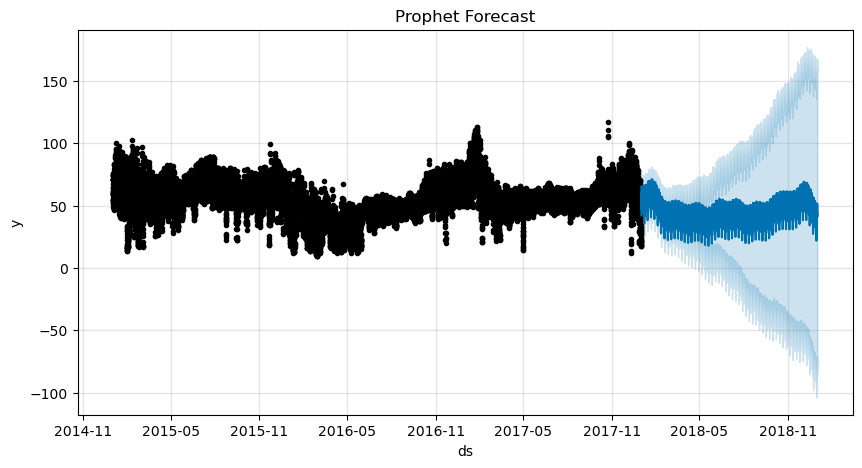

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(proph_fcst_sol, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

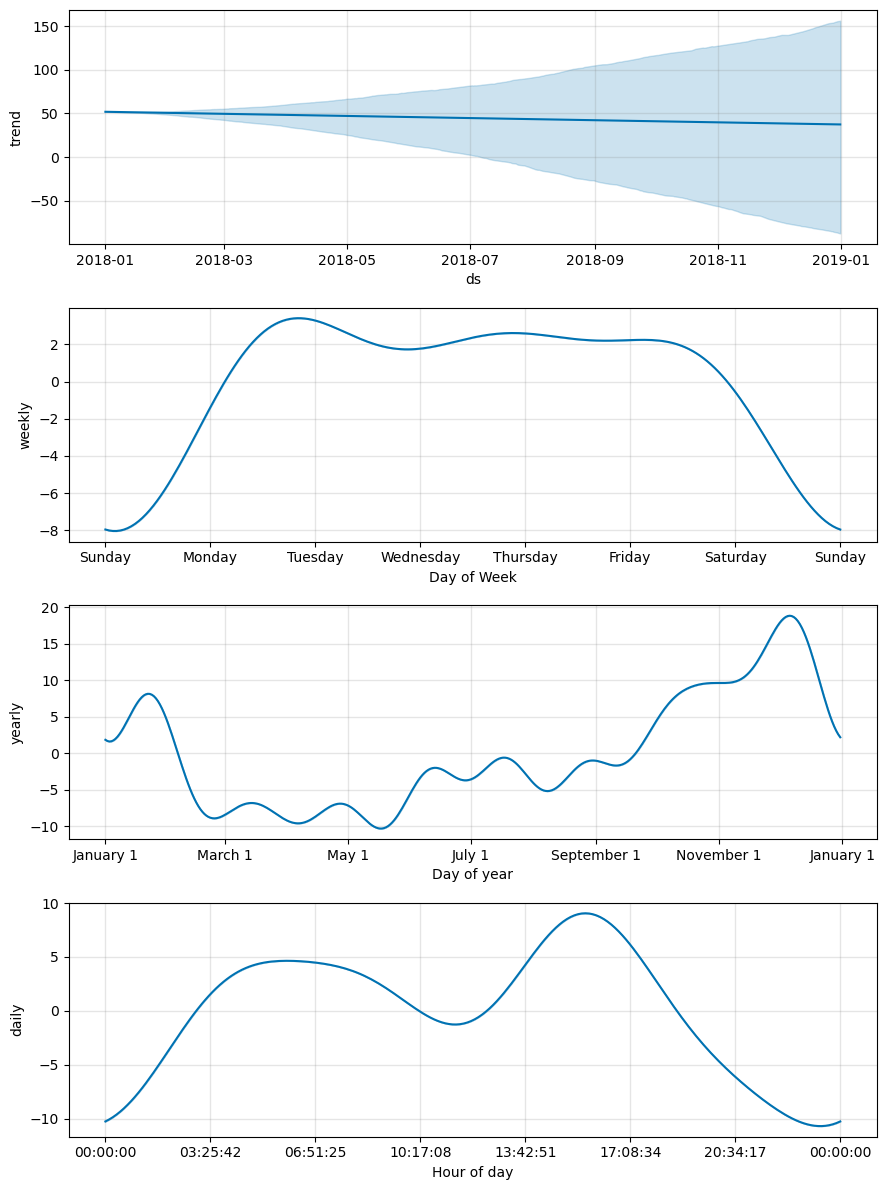

In [17]:
fig = model.plot_components(proph_fcst_sol)
plt.show()

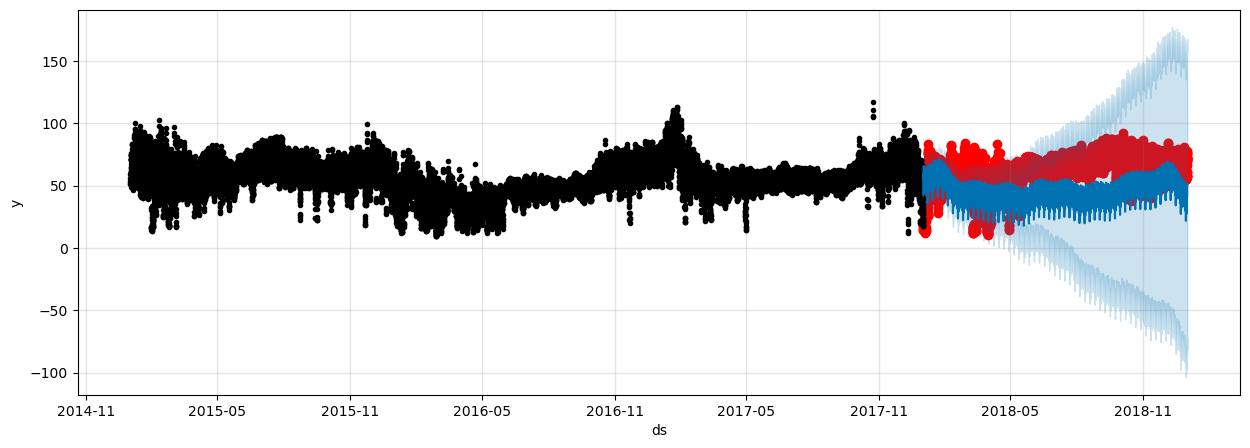

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(y_test.index, y_test, color='r')
fig = model.plot(proph_fcst_sol, ax=ax)

In [19]:
mse_prophet = mean_squared_error(y_true=df_y_test['y'], y_pred=proph_fcst_sol['yhat'])

print(f"Test MSE for Prophet: {mse_prophet}")

Test MSE for Prophet: 507.09425689360324


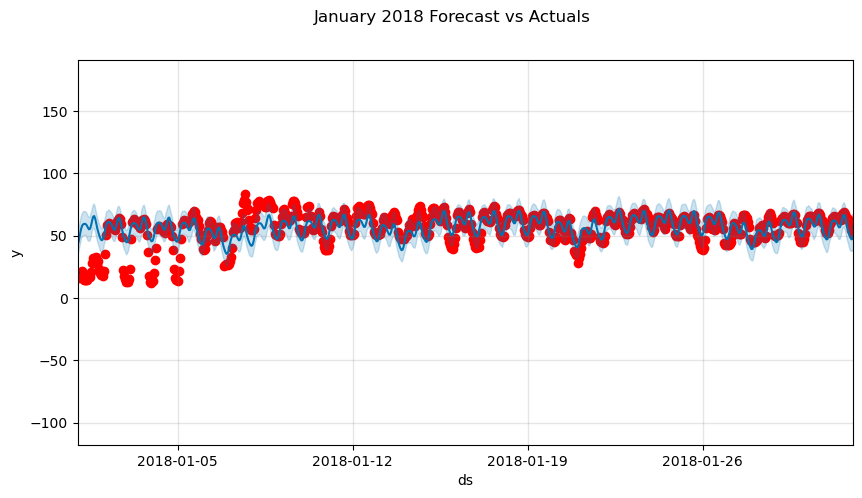

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test.index, y_test, color='r')
fig = model.plot(proph_fcst_sol, ax=ax)
ax.set_xbound(lower='01-01-2018',
              upper='02-01-2018')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2018 Forecast vs Actuals')

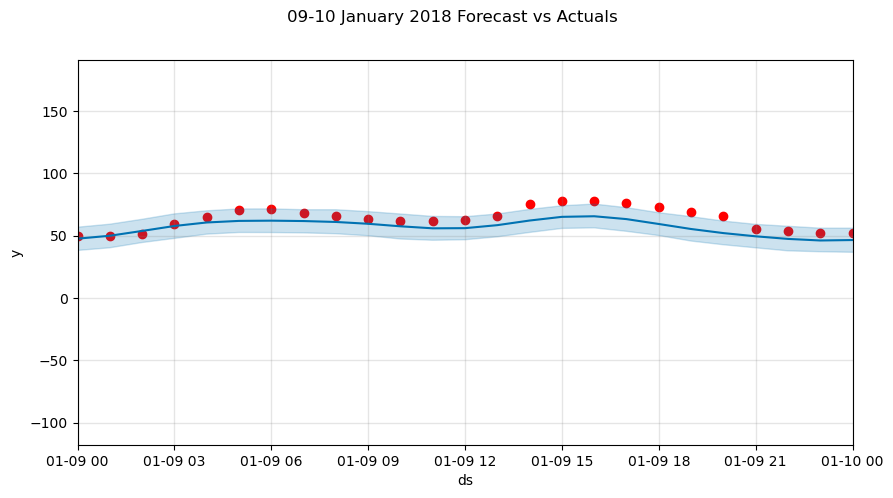

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test.index, y_test, color='r')
fig = model.plot(proph_fcst_sol, ax=ax)
ax.set_xbound(lower='01-09-2018',
              upper='01-10-2018')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('09-10 January 2018 Forecast vs Actuals')

In [49]:
df_wo_price = df.drop(columns=['price actual'])

In [25]:
def XGB(X_train, X_test, y_train, y_test, param_grid, scoring='neg_mean_squared_error', random_state=None):
    # Initialize and train the XGBoost classifier
    xg_reg = XGBRegressor(objective='reg:squarederror', random_state=random_state)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring=scoring, cv=5, verbose=1)
    grid_search.fit(X_train, y_train)

    # Print best parameters found by GridSearchCV
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    # Re-train the model with the best parameters on the full training set
    xgb_optimized = XGBRegressor(**best_params, use_label_encoder=False, objective='reg:squarederror', random_state=random_state)
    xgb_optimized.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_optimized = xgb_optimized.predict(X_test)
    # Set predictions less than zero to zero
    y_pred_optimized[y_pred_optimized < 0] = 0

    y_pred = pd.DataFrame(y_pred_optimized, columns=['Prediction'])

    # Calculate and print the scoring on the test set
    scoring_value = -mean_squared_error(y_test, y_pred)  # Multiply by -1 for neg_mean_squared_error
    print(f"Test set {scoring} with optimized parameters: {scoring_value:.4f}")
    
    return xgb_optimized, y_pred, best_params, scoring_value

In [26]:
# Example usage
param_grid = {
    'max_depth': [10],
    'alpha': [10],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'colsample_bytree': [0.8]
}


xgb_optimized, y_pred, best_params, MSE = XGB(X_train, X_test, y_train, y_test, param_grid, scoring='neg_mean_squared_error', random_state=42)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'alpha': 10, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Test set neg_mean_squared_error with optimized parameters: -33.9782


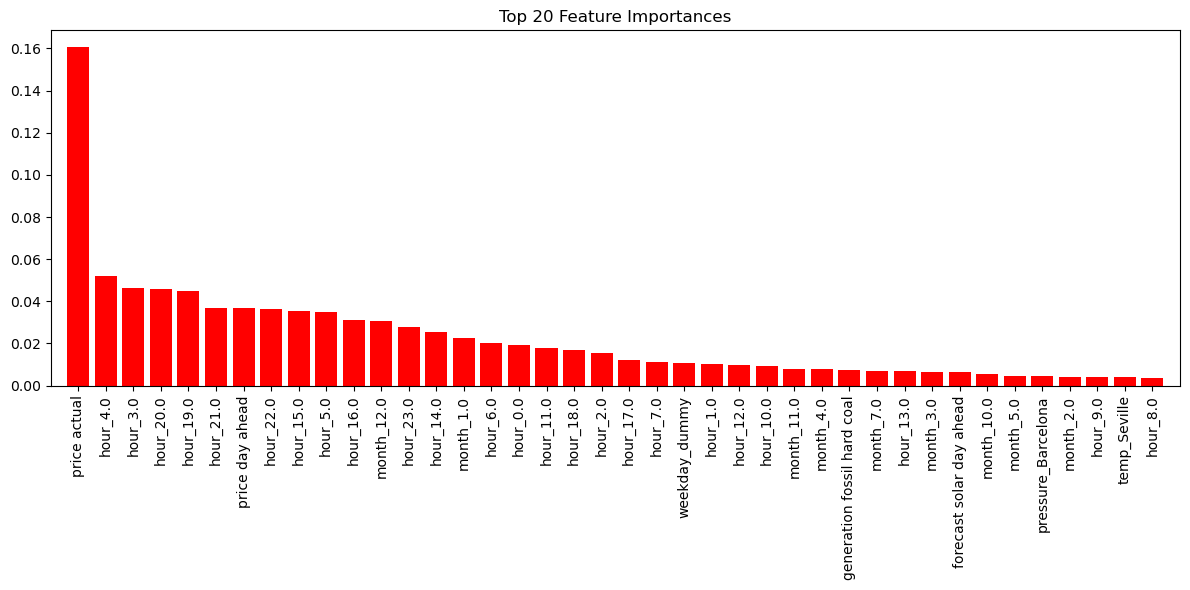

In [27]:
importances = xgb_optimized.feature_importances_
indices = np.argsort(importances)[::-1][:40]  # Select top 20 most important features
plt.figure(figsize=(12, 6))  # Increase width of the plot
plt.title('Top 20 Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='r', align='center')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.tight_layout()  # Adjust layout for better readability
plt.show()

In [30]:
df_y.head()

,ds,y
0,2014-12-31 23:00:00,59.32
1,2015-01-01 00:00:00,56.04
2,2015-01-01 01:00:00,53.63
3,2015-01-01 02:00:00,51.73
4,2015-01-01 03:00:00,51.43


In [29]:
model_2 = Prophet()
model_2.add_regressor()
model_2.fit(df_y)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [33]:
df_y['hour_4.0'] = df['hour_4.0']

In [36]:
df_y['hour_4.0'].fillna(0, inplace=True)
df_y.head()

,ds,y,hour_4.0
0,2014-12-31 23:00:00,59.32,0.0
1,2015-01-01 00:00:00,56.04,0.0
2,2015-01-01 01:00:00,53.63,0.0
3,2015-01-01 02:00:00,51.73,0.0
4,2015-01-01 03:00:00,51.43,0.0


In [37]:
model_2 = Prophet()
model_2.add_regressor('hour_4.0')
model_2.fit(df_y)

17:13:30 - cmdstanpy - INFO - Chain [1] start processing
17:13:49 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
df_y_test['hour_4.0'] = df['hour_4.0']
df_y_test['hour_4.0'].fillna(0, inplace=True)
df_y_test.head()

,ds,y,hour_4.0
0,2018-01-01 00:00:00,18.83,0.0
1,2018-01-01 01:00:00,15.80,0.0
2,2018-01-01 02:00:00,18.70,0.0
3,2018-01-01 03:00:00,19.97,0.0
4,2018-01-01 04:00:00,21.91,0.0


In [41]:
pred_w_hour4 = model_2.predict(df_y_test)

In [43]:
pred_w_hour4

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,51.922057,33.676023,51.906968,51.922057,51.922057,-9.752937,-9.752937,-9.752937,-10.247102,...,-1.381317,-1.381317,-1.381317,1.875482,1.875482,1.875482,0.0,0.0,0.0,42.169120
1,2018-01-01 01:00:00,51.920401,35.961872,55.300392,51.920401,51.920401,-6.933609,-6.933609,-6.933609,-7.849419,...,-0.949603,-0.949603,-0.949603,1.865412,1.865412,1.865412,0.0,0.0,0.0,44.986792
2,2018-01-01 02:00:00,51.918746,40.851249,58.490292,51.918746,51.918746,-2.603976,-2.603976,-2.603976,-3.930982,...,-0.528515,-0.528515,-0.528515,1.855520,1.855520,1.855520,0.0,0.0,0.0,49.314769
3,2018-01-01 03:00:00,51.917090,43.478390,62.896100,51.917090,51.917090,1.845736,1.845736,1.845736,0.120471,...,-0.120541,-0.120541,-0.120541,1.845805,1.845805,1.845805,0.0,0.0,0.0,53.762826
4,2018-01-01 04:00:00,51.915434,47.345427,66.393772,51.915434,51.915434,5.122809,5.122809,5.122809,3.014543,...,0.271997,0.271997,0.271997,1.836269,1.836269,1.836269,0.0,0.0,0.0,57.038243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,2018-12-31 15:00:00,37.433912,-88.146777,179.427401,-99.972006,160.620976,13.544282,13.544282,13.544282,8.374647,...,3.121812,3.121812,3.121812,2.047822,2.047822,2.047822,0.0,0.0,0.0,50.978193
8752,2018-12-31 16:00:00,37.432256,-87.976357,178.165211,-99.991867,160.649859,14.153648,14.153648,14.153648,8.890079,...,3.228476,3.228476,3.228476,2.035093,2.035093,2.035093,0.0,0.0,0.0,51.585904
8753,2018-12-31 17:00:00,37.430601,-89.227629,172.361249,-100.011729,160.678742,11.958723,11.958723,11.958723,6.625872,...,3.310310,3.310310,3.310310,2.022541,2.022541,2.022541,0.0,0.0,0.0,49.389324
8754,2018-12-31 18:00:00,37.428945,-95.704008,168.081695,-100.031590,160.707625,8.104635,8.104635,8.104635,2.726218,...,3.368251,3.368251,3.368251,2.010165,2.010165,2.010165,0.0,0.0,0.0,45.533580


In [42]:
mse_hour4_2 = mean_squared_error(y_true=df_y_test['y'], y_pred=pred_w_hour4['yhat'])

print(f"Test MSE for Prophet: {mse_prophet}")

Test MSE for Prophet: 507.09425689360324


In [44]:
model_3 = Prophet(daily_seasonality=False)  # Start without built-in daily seasonality
model_3.add_seasonality(name='daily', period=1, fourier_order=10)
model_3.fit(df_y)

17:28:19 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
pred_daily_seas = model_3.predict(df_y_test)

In [46]:
mse_daily_seas = mean_squared_error(y_true=df_y_test['y'], y_pred=pred_daily_seas['yhat'])

print(f"Test MSE for Prophet: {mse_prophet}")

Test MSE for Prophet: 507.09425689360324


In [47]:
mean_absolute_percentage_error(y_true=df_y_test['y'],
                   y_pred=proph_fcst_sol['yhat'])

0.31855045790969594

In [48]:
mean_absolute_error(y_true=df_y_test['y'],
                   y_pred=proph_fcst_sol['yhat'])

19.948943084929176